In [36]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL

from utils import FocalLoss, f1
from wrn4 import *

In [81]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TRAIN256 = Path('train256/')
TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [38]:
def open_image4d(fn:PathOrStr)->Image:
    "Return `Image` object created from image in file `fn`."
    x = PIL.Image.open(fn)
    return Image(pil2tensor(x).float().div_(255))

In [42]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [82]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, suffix='.png', label_delim=' ', fn_col=0, label_col=1)
test_fnames, _ = _df_to_fns_labels(sample_sub, suffix='.png', fn_col=0, label_col=1)

In [84]:
classes = uniqueify(np.concatenate(labels))

In [85]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [86]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [92]:
def get_data(sz=64, bs=64):
    test_ds=None
    if sz==64: folder=TRAIN64
    if sz==128: folder=TRAIN128
    if sz==256: 
        folder=TRAIN256
        test_ds = Image4C_ds.from_single_folder(test_fnames, classes)
        
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)

In [59]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN256, fnames, labels, valid_pct=0.2, classes=classes)

In [93]:
data64 = get_data(64, 128)

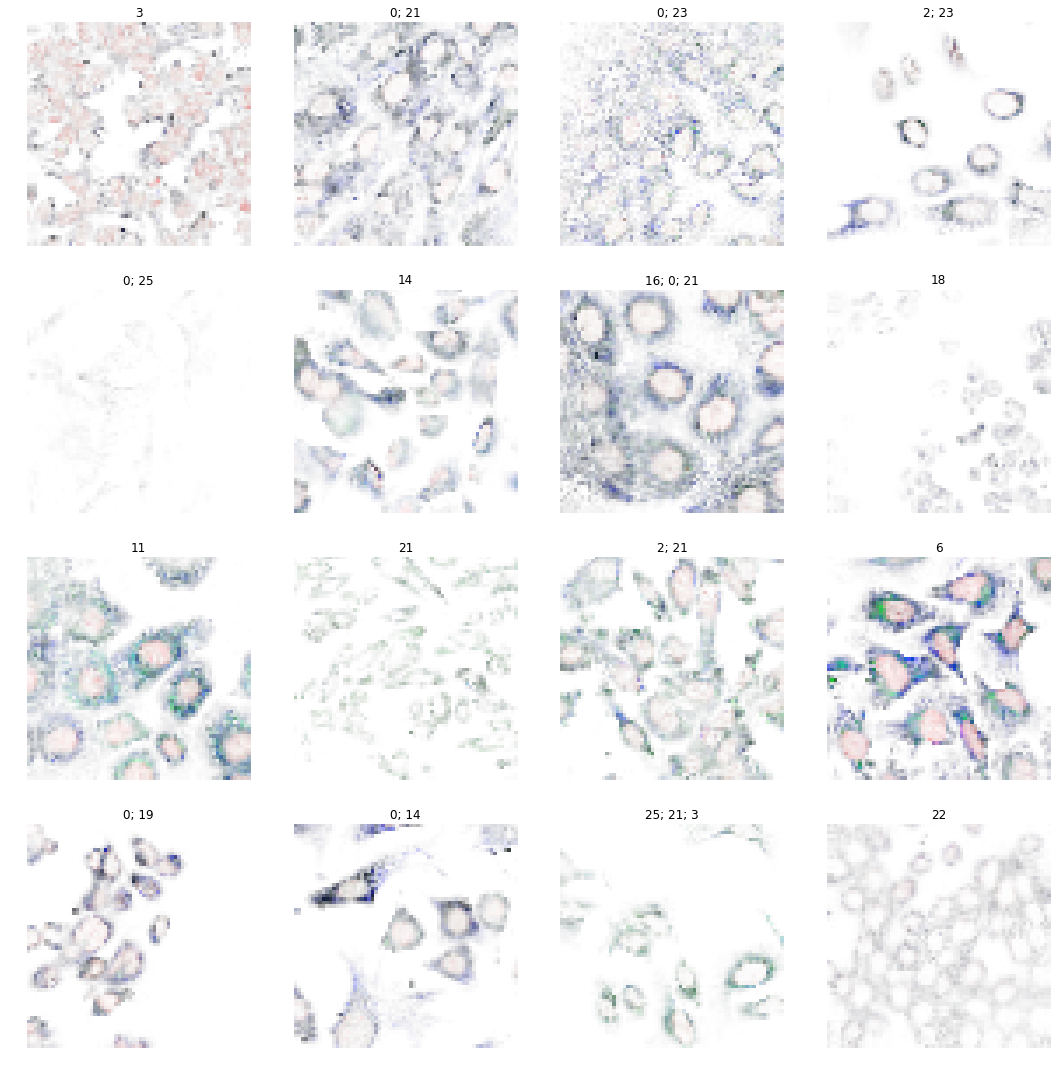

In [94]:
data64.show_batch(rows=4, figsize=(15,15))

In [19]:
# seg = pd.read_csv(PATH/MASKS)
# data64 = (ImageFileList.from_folder(PATH)
#         .label_from_df(seg, sep=' ', folder=TRAIN64, suffix='.png')  
#         .random_split_by_pct(0.2)
#         .datasets(Image4C_ds)  
#         .transform(tfms)             
#         .databunch()
#         .normalize(imagenet_stats))

In [95]:
arch = wrn_22_4()

In [51]:
learn = Learner(data64, arch , metrics=[accuracy_thresh, f1])

In [52]:
learn.loss_func = FocalLoss()

In [25]:
# learn.lr_find()

In [26]:
# learn.recorder.plot()

In [53]:
learn.to_fp16();

In [56]:
learn.load('wrn4_64')

In [63]:
%time learn.fit_one_cycle(10, 1e-2/3)

Total time: 17:24
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.881466    0.883445    0.959130         0.498629  (01:43)
2      0.880912    0.923767    0.957609         0.479972  (01:44)
3      0.921422    1.002022    0.953894         0.441459  (01:44)
4      0.893973    0.994725    0.954407         0.473033  (01:44)
5      0.894277    0.897901    0.958361         0.516839  (01:44)
6      0.867101    0.881905    0.959609         0.482853  (01:44)
7      0.858531    0.846748    0.960474         0.523779  (01:44)
8      0.840473    0.839107    0.960907         0.537358  (01:44)
9      0.844043    0.829267    0.961329         0.536815  (01:44)
10     0.832181    0.827664    0.961409         0.540755  (01:44)

CPU times: user 10min 47s, sys: 6min 29s, total: 17min 16s
Wall time: 17min 24s


In [58]:
learn.save('wrn4_128')